In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

print(os.getenv("LANGCHAIN_PROJECT"))

agent-book


In [2]:
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確で分かりやすい回答を提供してください。"
    },
    "2": {
        "name": "生成AI製品エキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。"
    },
    "3": {
        "name": "カウンセラー",
        "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
        "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。"
    }
}

In [3]:
import operator
from typing import Annotated
from langchain_core.pydantic_v1 import BaseModel, Field

class State(BaseModel):
    query: str = Field(
        ..., description="ユーザからの質問"
    )
    current_role: str = Field(
        default="", description="選定された回答ロール"
    )
    messages: Annotated[list[str], operator.add] = Field(
        default=[], description="回答履歴"
    )
    current_judge: bool = Field(
        default=False, description="品質チェックの結果"
    )
    judgement_reason: str = Field(
        default="", description="品質チェックの理由"
    )

In [4]:
from langchain_anthropic import ChatAnthropic
from langchain_core.runnables import ConfigurableField

llm = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0.0)
llm = llm.configurable_fields(max_tokens=ConfigurableField(id='max_tokens'))

In [5]:
from typing import Any

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def selection_node(state: State) -> dict[str, Any]:
    query = state.query
    role_options = "\n".join([f"{k}. {v['description']}" for k, v in ROLES.items()])
    prompt = ChatPromptTemplate.from_template(
"""質問を分析し、最も適切な回答担当ロールを選択してください。

選択肢:
{role_options}

回答は選択肢の番号(1,2,または3)のみを返してください。

質問: {query}
""".strip()
    )
    # 選択肢の番号のみを返すことを期待したいため、max_tokensを1に設定
    chain = prompt | llm.with_config(configuarable=dict(max_tokens=1)) | StrOutputParser()
    role_number = chain.invoke({"role_options": role_options, "query": query})

    selected_role = ROLES[role_number.strip()]['name']
    return { "current_role": selected_role }


In [7]:
def answer_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role
    role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()])
    prompt = ChatPromptTemplate.from_template(
"""あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。

役割の詳細:
{role_details}

質問: {query}

回答:""".strip()
    )
    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})
    return { "messages": [answer] }


In [10]:
class Judgement(BaseModel):    
    reason: str = Field(default="", description="判断理由")
    judge: bool = Field(default=False, description="品質チェックの結果")


def check_node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]
    prompt = ChatPromptTemplate.from_template(
"""以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'を回答してください。また、その判断理由も説明してください。

ユーザからの質問: {query}
回答: {answer}
""".strip()
    )
    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {
        "current_judge": result.judge,
        "judgement_reason": result.reason
    }

In [9]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)

In [13]:
workflow.add_node("selection", selection_node)
workflow.add_node("answer", answer_node)
workflow.add_node("check", check_node)

ValueError: Node `selection` already present.

In [14]:
# selectionノードから処理を開始
workflow.set_entry_point("selection")
# selectionノードからansweringノードへ遷移
workflow.add_edge("selection", "answer")
# answeringノードからcheckノードへ遷移
workflow.add_edge("answer", "check")

In [15]:
from langgraph.graph import END

# checkノードから次のノードへの遷移に条件付きエッジを定義
workflow.add_conditional_edges(
    "check",
    lambda state: state.current_judge,
    {True: END, False: "selection"}
)

In [16]:
compiled = workflow.compile()

In [17]:
init_state = State(query="生成AIについて教えてください")
result = compiled.invoke(init_state)

In [18]:
print(result)

{'query': '生成AIについて教えてください', 'current_role': '生成AI製品エキスパート', 'messages': ['はい、生成AIについて詳しく説明させていただきます。\n\n生成AIとは、人工知能技術を使って新しいコンテンツを自動的に生成する技術です。これには主に以下のようなものがあります:\n\n- 言語モデル: 大量のテキストデータを学習し、人間のような自然言語を生成することができます。GPT-3やChatGPTなどがその代表例です。\n\n- 画像生成モデル: 大量の画像データを学習し、新しい画像を生成することができます。DALL-Eやステーブル・ディフューションなどがあります。\n\n- 音声合成モデル: 音声データを学習し、人間の声を模倣して新しい音声を生成することができます。Whisperなどがその例です。\n\nこれらの生成AIは、創造性や生産性の向上、新しいアイデアの創出など、さまざまな用途が期待されています。一方で、倫理的な懸念や著作権の問題など、課題もあります。\n\n生成AIの技術は日々進化しており、今後さらなる発展が予想されます。適切に活用していくことが重要です。ご質問ありがとうございました。'], 'current_judge': True, 'judgement_reason': 'この回答は生成AIの概要を簡潔かつ分かりやすく説明しており、ユーザの質問に適切に答えています。回答内容に問題はありません。'}


In [19]:
print(result["messages"][-1])

はい、生成AIについて詳しく説明させていただきます。

生成AIとは、人工知能技術を使って新しいコンテンツを自動的に生成する技術です。これには主に以下のようなものがあります:

- 言語モデル: 大量のテキストデータを学習し、人間のような自然言語を生成することができます。GPT-3やChatGPTなどがその代表例です。

- 画像生成モデル: 大量の画像データを学習し、新しい画像を生成することができます。DALL-Eやステーブル・ディフューションなどがあります。

- 音声合成モデル: 音声データを学習し、人間の声を模倣して新しい音声を生成することができます。Whisperなどがその例です。

これらの生成AIは、創造性や生産性の向上、新しいアイデアの創出など、さまざまな用途が期待されています。一方で、倫理的な懸念や著作権の問題など、課題もあります。

生成AIの技術は日々進化しており、今後さらなる発展が予想されます。適切に活用していくことが重要です。ご質問ありがとうございました。


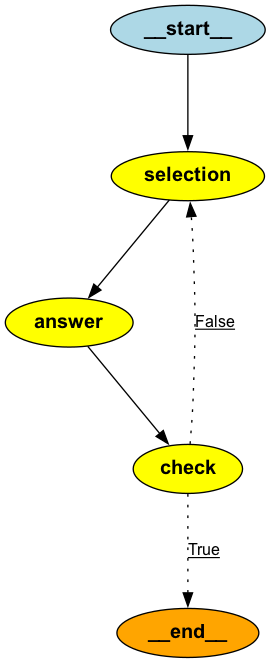

In [21]:
from IPython.display import Image

Image(compiled.get_graph().draw_png())

In [29]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver

def print_checkpoint_dump(checkpointer: BaseCheckpointSaver, config: RunnableConfig) -> None:
    checkpoint_tuple = checkpointer.get_tuple(config)

    print("チェックポイントデータ:")
    pprint(checkpoint_tuple.checkpoint)
    print("\nメタデータ:")
    pprint(checkpoint_tuple.metadata)

In [23]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

compiled_graph = workflow.compile(checkpointer=checkpointer)

In [25]:
config = {"configurable": {"thread_id": "example_1"}}
init_state = State(query="生成AIについて教えてください")
result = compiled_graph.invoke(init_state, config)
result

{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['はい、生成AIについて詳しく説明させていただきます。\n\n生成AIとは、人工知能技術を使って新しいコンテンツを自動的に生成する技術です。これには主に以下のような特徴があります:\n\n- 言語モデルを使って自然言語を生成する言語生成AI\n- 画像生成AI (DALL-E、Stable Diffusion など)で新しい画像を生成する\n- 音声合成AIで人工的な音声を生成する\n- 音楽生成AIで新しい楽曲を作り出す\n\nこれらの生成AIは、膨大なデータを学習することで、人間が作るのと似たような新しいコンテンツを生み出すことができます。\n\n生成AIの大きな特徴は、創造性と生産性の向上にあります。人間が手作業で行っていた作業を自動化できるため、効率的にコンテンツを生み出すことができます。また、人間の発想を超えた新しいアイデアを生み出すこともできます。\n\n一方で、生成AIにはいくつかの課題もあります。倫理的な問題や、著作権侵害のリスク、生成物の品質管理など、慎重に扱う必要があります。\n\n生成AIは急速に進化しており、今後さまざまな分野で活用されていくことが期待されています。ただし、人間の創造性を補完するツールとして活用していくことが重要だと考えています。'],
 'current_judge': True,
 'judgement_reason': 'この回答は生成AIの概要を適切に説明しており、問題はないと判断しました。回答は生成AIの特徴、メリット、課題などを簡潔にまとめており、ユーザの質問に対して十分な情報を提供しています。'}

In [27]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example_1', 'checkpoint_ns': '', 'checkpoint_id': '1f05a1cb-df66-6a0a-8003-30f92f7f1edb'}}, checkpoint={'v': 4, 'ts': '2025-07-06T03:53:14.111218+00:00', 'id': '1f05a1cb-df66-6a0a-8003-30f92f7f1edb', 'channel_versions': {'__start__': '00000000000000000000000000000002.0.7046678504183621', 'query': '00000000000000000000000000000002.0.7046678504183621', 'current_role': '00000000000000000000000000000003.0.10467428556484415', 'messages': '00000000000000000000000000000004.0.995235724542301', 'current_judge': '00000000000000000000000000000005.0.7272335141860979', 'judgement_reason': '00000000000000000000000000000005.0.7272335141860979', 'branch:to:selection': '00000000000000000000000000000003.0.10467428556484415', 'branch:to:answer': '00000000000000000000000000000004.0.995235724542301', 'branch:to:check': '00000000000000000000000000000005.0.7272335141860979'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '0000000000000000

In [30]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'current_judge': True,
                    'current_role': '生成AI製品エキスパート',
                    'judgement_reason': 'この回答は生成AIの概要を適切に説明しており、問題はないと判断しました。回答は生成AIの特徴、メリット、課題などを簡潔にまとめており、ユーザの質問に対して十分な情報を提供しています。',
                    'messages': ['はい、生成AIについて詳しく説明させていただきます。\n'
                                 '\n'
                                 '生成AIとは、人工知能技術を使って新しいコンテンツを自動的に生成する技術です。これには主に以下のような特徴があります:\n'
                                 '\n'
                                 '- 言語モデルを使って自然言語を生成する言語生成AI\n'
                                 '- 画像生成AI (DALL-E、Stable Diffusion '
                                 'など)で新しい画像を生成する\n'
                                 '- 音声合成AIで人工的な音声を生成する\n'
                                 '- 音楽生成AIで新しい楽曲を作り出す\n'
                                 '\n'
                                 'これらの生成AIは、膨大なデータを学習することで、人間が作るのと似たような新しいコンテンツを生み出すことができます。\n'
                                 '\n'
                                 '生成AIの大きな特徴は、創

In [ ]:
d